In [1]:
import fsspec

In [2]:
fs_read = fsspec.filesystem('s3', anon=True, skip_instance_cache=True, use_ssl=False) # For now SSL false is solving my cert issues **shrug**
fs_write = fsspec.filesystem('') # For now we are writing to local disk

Read in kerchunked zarr files from the nextgen-dmac bucket

In [3]:
dbofs_files = fs_read.glob('s3://nextgen-dmac/nos/nos.dbofs.fields.f*.*.t*z.nc.zarr')

dbofs_files = sorted(['s3://'+f for f in dbofs_files])
dbofs_files

['s3://nextgen-dmac/nos/nos.dbofs.fields.f001.20230315.t00z.nc.zarr',
 's3://nextgen-dmac/nos/nos.dbofs.fields.f001.20230315.t06z.nc.zarr',
 's3://nextgen-dmac/nos/nos.dbofs.fields.f001.20230315.t12z.nc.zarr',
 's3://nextgen-dmac/nos/nos.dbofs.fields.f001.20230315.t18z.nc.zarr',
 's3://nextgen-dmac/nos/nos.dbofs.fields.f001.20230316.t00z.nc.zarr',
 's3://nextgen-dmac/nos/nos.dbofs.fields.f001.20230316.t06z.nc.zarr',
 's3://nextgen-dmac/nos/nos.dbofs.fields.f001.20230316.t12z.nc.zarr',
 's3://nextgen-dmac/nos/nos.dbofs.fields.f001.20230316.t18z.nc.zarr',
 's3://nextgen-dmac/nos/nos.dbofs.fields.f001.20230317.t00z.nc.zarr',
 's3://nextgen-dmac/nos/nos.dbofs.fields.f001.20230317.t06z.nc.zarr',
 's3://nextgen-dmac/nos/nos.dbofs.fields.f001.20230317.t12z.nc.zarr',
 's3://nextgen-dmac/nos/nos.dbofs.fields.f001.20230317.t18z.nc.zarr',
 's3://nextgen-dmac/nos/nos.dbofs.fields.f001.20230318.t00z.nc.zarr',
 's3://nextgen-dmac/nos/nos.dbofs.fields.f001.20230318.t06z.nc.zarr',
 's3://nextgen-dmac/

In [ ]:
import re

def extract_date(filename):
    n, dd, hh =  re.search(r'\d{8}T\d{6}', filename).groups()

In [4]:
from kerchunk.combine import MultiZarrToZarr
import ujson

In [5]:
def nos_filename_to_reftime(index, fs, var, fn): 
    import re
    import datetime

    dd, hh = re.search(r'(\d{8}).t(\d{2})', fn).groups()
    return datetime.datetime.strptime(dd+hh, '%Y%m%d%H')

mzz = MultiZarrToZarr(
    dbofs_files, 
    remote_protocol='s3', 
    remote_options={'anon': True, 'use_ssl': False},
    coo_map={'forecast_reference_time': nos_filename_to_reftime},
    coo_dtypes={'forecast_reference_time': 'datetime64[ns]'},
    concat_dims=['ocean_time', 'forecast_reference_time'],
    identical_dims=['eta_rho', 'xi_rho', 's_rho', 'eta_psi', 'xi_psi', 's_w', 'eta_u', 'xi_u', 'eta_v', 'xi_v', 'lat_rho', 'lat_psi', 'lat_u', 'lat_v', 'lon_rho', 'lon_psi', 'lon_u', 'lon_v']
)

d = mzz.translate()

with fs_write.open('nos.dbofs.fields.all.zarr', 'wb') as f:
    f.write(ujson.dumps(d).encode())
    print('Successfully wrote kerchunked nos collection to disk')

Successfully wrote kerchunked nos collection to disk


In [6]:
import xarray as xr

# open dataset as zarr object using fsspec reference file system and xarray
fs = fsspec.filesystem("reference", fo='nos.dbofs.fields.all.zarr', remote_protocol='s3', remote_options={'anon':True, 'use_ssl': False})
m = fs.get_mapper("") 

ds = xr.open_dataset(m, engine="zarr", backend_kwargs=dict(consolidated=False), 
                      chunks={'ocean_time':1, 'forecast_reference_time': 1})
ds

<xarray.Dataset>
Dimensions:                  (ocean_time: 204, forecast_reference_time: 27,
                              tracer: 2, s_rho: 10, s_w: 11, boundary: 4,
                              eta_rho: 732, xi_rho: 119, eta_psi: 731,
                              xi_psi: 118, eta_u: 732, xi_u: 118, eta_v: 731,
                              xi_v: 119)
Coordinates:
  * forecast_reference_time  (forecast_reference_time) datetime64[ns] 2023-03...
    lat_psi                  (eta_psi, xi_psi) float64 dask.array<chunksize=(731, 118), meta=np.ndarray>
    lat_rho                  (eta_rho, xi_rho) float64 dask.array<chunksize=(732, 119), meta=np.ndarray>
    lat_u                    (eta_u, xi_u) float64 dask.array<chunksize=(732, 118), meta=np.ndarray>
    lat_v                    (eta_v, xi_v) float64 dask.array<chunksize=(731, 119), meta=np.ndarray>
    lon_psi                  (eta_psi, xi_psi) float64 dask.array<chunksize=(731, 118), meta=np.ndarray>
    lon_rho                  (eta_rho, xi_rho) float64 dask.array<chunksize=(732, 119), meta=np.ndarray>
    lon_u                    (eta_u, xi_u) float64 dask.array<chunksize=(732, 118), meta=np.ndarray>
    lon_v                    (eta_v, xi_v) float64 dask.array<chunksize=(731, 119), meta=np.ndarray>
  * ocean_time               (ocean_time) datetime64[ns] 2023-03-15T01:00:00 ...
  * s_rho                    (s_rho) float64 -0.95 -0.85 -0.75 ... -0.15 -0.05
  * s_w                      (s_w) float64 -1.0 -0.9 -0.8 -0.7 ... -0.2 -0.1 0.0
Dimensions without coordinates: tracer, boundary, eta_rho, xi_rho, eta_psi,
                                xi_psi, eta_u, xi_u, eta_v, xi_v
Data variables: (12/79)
    Akk_bak                  (ocean_time, forecast_reference_time) float64 dask.array<chunksize=(1, 1), meta=np.ndarray>
    Akp_bak                  (ocean_time, forecast_reference_time) float64 dask.array<chunksize=(1, 1), meta=np.ndarray>
    Akt_bak                  (ocean_time, forecast_reference_time, tracer) float64 dask.array<chunksize=(1, 1, 2), meta=np.ndarray>
    Akv_bak                  (ocean_time, forecast_reference_time) float64 dask.array<chunksize=(1, 1), meta=np.ndarray>
    Cs_r                     (ocean_time, forecast_reference_time, s_rho) float64 dask.array<chunksize=(1, 1, 10), meta=np.ndarray>
    Cs_w                     (ocean_time, forecast_reference_time, s_w) float64 dask.array<chunksize=(1, 1, 11), meta=np.ndarray>
    ...                       ...
    theta_s                  (ocean_time, forecast_reference_time) float64 dask.array<chunksize=(1, 1), meta=np.ndarray>
    u                        (forecast_reference_time, ocean_time, s_rho, eta_u, xi_u) float32 dask.array<chunksize=(1, 1, 10, 732, 118), meta=np.ndarray>
    v                        (forecast_reference_time, ocean_time, s_rho, eta_v, xi_v) float32 dask.array<chunksize=(1, 1, 10, 731, 119), meta=np.ndarray>
    w                        (forecast_reference_time, ocean_time, s_w, eta_rho, xi_rho) float32 dask.array<chunksize=(1, 1, 6, 732, 119), meta=np.ndarray>
    xl                       (ocean_time, forecast_reference_time) float64 dask.array<chunksize=(1, 1), meta=np.ndarray>
    zeta                     (forecast_reference_time, ocean_time, eta_rho, xi_rho) float32 dask.array<chunksize=(1, 1, 732, 119), meta=np.ndarray>
Attributes: (12/33)
    CPP_options:       mode, ADD_FSOBC, ADD_M2OBC, ANA_BSFLUX, ANA_BTFLUX, AN...
    Conventions:       CF-1.4, SGRID-0.3
    NLM_LBC:           \nEDGE:  WEST   SOUTH  EAST   NORTH  \nzeta:  Cha    C...
    NLM_TADV:          \nADVECTION:   HORIZONTAL   VERTICAL     \ntemp:      ...
    ana_file:          ROMS/Functionals/ana_btflux.h, ROMS/Functionals/ana_ra...
    bry_file_01:       nos.dbofs.obc.20230315.t00z.nc
    ...                ...
    svn_url:           
    tide_file:         nos.dbofs.roms.tides.nc
    tiling:            008x016
    title:             dbofs forecast RUN in operational mode
    type:              ROMS/TOMS history f

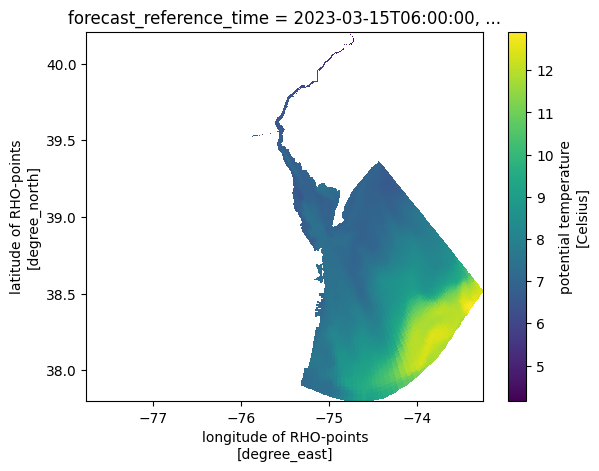

In [7]:
ds.temp.isel(ocean_time=6, forecast_reference_time=1, s_rho=0).plot(x='lon_rho', y="lat_rho")

In [20]:
ds.isel(forecast_reference_time=-1)

<xarray.Dataset>
Dimensions:                  (ocean_time: 180, tracer: 2, s_rho: 10, s_w: 11,
                              boundary: 4, eta_rho: 732, xi_rho: 119,
                              eta_psi: 731, xi_psi: 118, eta_u: 732, xi_u: 118,
                              eta_v: 731, xi_v: 119)
Coordinates:
    forecast_reference_time  datetime64[ns] 2023-03-20T12:00:00
    lat_psi                  (eta_psi, xi_psi) float64 dask.array<chunksize=(731, 118), meta=np.ndarray>
    lat_rho                  (eta_rho, xi_rho) float64 dask.array<chunksize=(732, 119), meta=np.ndarray>
    lat_u                    (eta_u, xi_u) float64 dask.array<chunksize=(732, 118), meta=np.ndarray>
    lat_v                    (eta_v, xi_v) float64 dask.array<chunksize=(731, 119), meta=np.ndarray>
    lon_psi                  (eta_psi, xi_psi) float64 dask.array<chunksize=(731, 118), meta=np.ndarray>
    lon_rho                  (eta_rho, xi_rho) float64 dask.array<chunksize=(732, 119), meta=np.ndarray>
    lon_u                    (eta_u, xi_u) float64 dask.array<chunksize=(732, 118), meta=np.ndarray>
    lon_v                    (eta_v, xi_v) float64 dask.array<chunksize=(731, 119), meta=np.ndarray>
  * ocean_time               (ocean_time) datetime64[ns] 2023-03-15T01:00:00 ...
  * s_rho                    (s_rho) float64 -0.95 -0.85 -0.75 ... -0.15 -0.05
  * s_w                      (s_w) float64 -1.0 -0.9 -0.8 -0.7 ... -0.2 -0.1 0.0
Dimensions without coordinates: tracer, boundary, eta_rho, xi_rho, eta_psi,
                                xi_psi, eta_u, xi_u, eta_v, xi_v
Data variables: (12/79)
    Akk_bak                  (ocean_time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    Akp_bak                  (ocean_time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    Akt_bak                  (ocean_time, tracer) float64 dask.array<chunksize=(1, 2), meta=np.ndarray>
    Akv_bak                  (ocean_time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    Cs_r                     (ocean_time, s_rho) float64 dask.array<chunksize=(1, 10), meta=np.ndarray>
    Cs_w                     (ocean_time, s_w) float64 dask.array<chunksize=(1, 11), meta=np.ndarray>
    ...                       ...
    theta_s                  (ocean_time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    u                        (ocean_time, s_rho, eta_u, xi_u) float32 dask.array<chunksize=(1, 10, 732, 118), meta=np.ndarray>
    v                        (ocean_time, s_rho, eta_v, xi_v) float32 dask.array<chunksize=(1, 10, 731, 119), meta=np.ndarray>
    w                        (ocean_time, s_w, eta_rho, xi_rho) float32 dask.array<chunksize=(1, 6, 732, 119), meta=np.ndarray>
    xl                       (ocean_time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    zeta                     (ocean_time, eta_rho, xi_rho) float32 dask.array<chunksize=(1, 732, 119), meta=np.ndarray>
Attributes: (12/33)
    CPP_options:       mode, ADD_FSOBC, ADD_M2OBC, ANA_BSFLUX, ANA_BTFLUX, AN...
    Conventions:       CF-1.4, SGRID-0.3
    NLM_LBC:           \nEDGE:  WEST   SOUTH  EAST   NORTH  \nzeta:  Cha    C...
    NLM_TADV:          \nADVECTION:   HORIZONTAL   VERTICAL     \ntemp:      ...
    ana_file:          ROMS/Functionals/ana_btflux.h, ROMS/Functionals/ana_ra...
    bry_file_01:       nos.dbofs.obc.20230315.t00z.nc
    ...                ...
    svn_url:           
    tide_file:         nos.dbofs.roms.tides.nc
    tiling:            008x016
    title:             dbofs forecast RUN in operational mode
    type:              ROMS/TOMS history file
    var_info:          varinfo.yaml